In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks')

In [0]:
import pandas as pd
import numpy as np
import math

In [0]:
train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/sets_de_datos/dima_train_with_features_2.csv")

In [0]:
X_test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/sets_de_datos/dima_test_with_features_2.csv")

In [0]:
mega_set = train.drop(['precio'], axis = 1).append(X_test, ignore_index = True)

In [0]:
mega_set_comercial = mega_set.loc[mega_set['tipodepropiedad'].isin(['Terreno comercial', 
                                             'Local Comercial', 
                                             'Oficina comercial',
                                             'Local en centro comercial', 
                                             'Bodega comercial'])]

In [0]:
mega_set_comercial_lat_lng = mega_set_comercial[['tipodepropiedad', 'lat', 'lng']].copy()

In [0]:
mega_set_comercial_lat_lng['lat_lng'] = mega_set_comercial_lat_lng.apply(lambda x: (x['lat'], x['lng']), axis = 1)

In [0]:
mega_set_comercial_lat_lng_grupo = mega_set_comercial_lat_lng.groupby(['tipodepropiedad']).agg({'lat_lng' : 'unique'})
mega_set_comercial_lat_lng_grupo['lat_lng'] = mega_set_comercial_lat_lng_grupo['lat_lng'].transform(lambda lista: [[x,y] for x,y in lista])
lat_lng_todas_comerciales = mega_set_comercial_lat_lng_grupo.to_dict()

In [0]:
from sklearn.neighbors import NearestNeighbors

In [0]:
#from sklearn.neighbors import LSHForest # No esta instalada

In [0]:
nbrs = NearestNeighbors(n_neighbors=1)
nbrs.fit(lat_lng_todas_comerciales['lat_lng']['Terreno comercial'])
nbrs.kneighbors([[1, 1]])

1.4142135623730951

In [0]:
todos_nbrs = {}
for tipodepropiedad in ['Terreno comercial', 'Local Comercial', 'Oficina comercial',
                        'Local en centro comercial','Bodega comercial']:
  nbrs = NearestNeighbors(n_neighbors=1)
  nbrs.fit(lat_lng_todas_comerciales['lat_lng'][tipodepropiedad])
  todos_nbrs[tipodepropiedad] = nbrs

In [0]:
for tipodepropiedad in ['Terreno comercial', 'Local Comercial', 'Oficina comercial',
                        'Local en centro comercial', 'Bodega comercial']:
      train['distancia_minima_' + "_".join(tipodepropiedad.split(' '))] =\
        train.apply(lambda x: 
                        todos_nbrs[tipodepropiedad]\
                          .kneighbors([[x['lat'], x['lng']]])[0][0][0],
                        axis = 1)

In [0]:
for tipodepropiedad in ['Terreno comercial', 'Local Comercial', 'Oficina comercial',
                        'Local en centro comercial', 'Bodega comercial']:
      X_test['distancia_minima_' + "_".join(tipodepropiedad.split(' '))] =\
        X_test.apply(lambda x: 
                        todos_nbrs[tipodepropiedad]\
                          .kneighbors([[x['lat'], x['lng']]])[0][0][0],
                        axis = 1)

In [0]:
train.to_csv("/content/drive/My Drive/Colab Notebooks/sets_de_datos/dima_train_with_features_4.csv", index = False)

In [0]:
X_test.to_csv("/content/drive/My Drive/Colab Notebooks/sets_de_datos/dima_test_with_features_4.csv", index = False)

In [0]:
train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/sets_de_datos/dima_train_with_features_4.csv")

In [0]:
X_test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/sets_de_datos/dima_test_with_features_4.csv")

In [0]:
train.set_index('id', inplace = True)
X_test.set_index('id', inplace = True)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
def evaluar_modelo(modelo, XX_test, y_test):
    y_pred = modelo.predict(XX_test)
    errors = abs(y_pred - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Performance del modelo:')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy

In [0]:
def plot_importance(modelo, feature_nombres):
  feature_importancias = modelo.feature_importances_ 
  indices_importancia = np.argsort(feature_importancias)
  plot = sns.barplot(
              y = feature_nombres[indices_importancia],
              x = feature_importancias[indices_importancia],
          )

  plot.set_xlabel('Importancia', fontsize = 15)
  plot.set_ylabel('Features', fontsize = 15)
  plot.set_title('Importancia features', fontsize = 20)
  fig = plot.get_figure()
  fig.set_size_inches(15,15)
  plt.show()
  return feature_nombres[indices_importancia]

In [0]:
TARGET = 'precio'
FEATURES = ['titulo', 'descripcion', 'tipodepropiedad', 'direccion', 'ciudad',
       'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lng', 'fecha',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'servicios_cercanos', 'utilidades_extra',
       'tipodepropiedad_mean_antiguedad', 'tipodepropiedad_mean_habitaciones',
       'tipodepropiedad_mean_garages', 'tipodepropiedad_mean_banos',
       'tipodepropiedad_mean_metroscubiertos',
       'tipodepropiedad_mean_utilidades_extra',
       'tipodepropiedad_mean_servicios_cercanos', 'ciudad_mean_antiguedad',
       'ciudad_mean_habitaciones', 'ciudad_mean_garages', 'ciudad_mean_banos',
       'ciudad_mean_metroscubiertos', 'ciudad_mean_utilidades_extra',
       'ciudad_mean_servicios_cercanos', 'provincia_mean_antiguedad',
       'provincia_mean_habitaciones', 'provincia_mean_garages',
       'provincia_mean_banos', 'provincia_mean_metroscubiertos',
       'provincia_mean_utilidades_extra', 'provincia_mean_servicios_cercanos',
       'ciudad_mean_lat', 'ciudad_mean_lng', 'provincia_mean_lat',
       'provincia_mean_lng', 'coseno_distancia_angular_al_centro_ciudad',
       'coseno_distancia_angular_al_centro_provincia',
       'coseno_distancia_angular_al_centro_pais', 'año', 'mes', 'dia',
       'metros_no_cubiertos', 'cantidad_espacios', 'metros_x_espacio',
       'metros_x_habitaciones', 'metros_x_garages', 'metros_x_banos',
       'metros_x_utilidades_extra', 'ratio_metros_cubiertos',
       'distancia_minima_Terreno_comercial',
       'distancia_minima_Local_Comercial',
       'distancia_minima_Oficina_comercial',
       'distancia_minima_Local_en_centro_comercial',
       'distancia_minima_Bodega_comercial']

In [14]:
len(FEATURES)

67

In [17]:
2**6

64

In [0]:
params = {'max_depth': 15, 'max_features': 5, 'n_estimators': 200}
rf_regressor = RandomForestRegressor(**params)

In [0]:
drop_columns_1 = ['titulo', 'descripcion', 'tipodepropiedad', 'direccion', 'ciudad', 'provincia', 'fecha', 'mes', 'dia']
FEATURES_1 = list(set(FEATURES) - set(drop_columns_1))

In [0]:
X_train_1, XX_test_1, y_train_1, y_test_1 = train_test_split(train[FEATURES_1], train[TARGET], test_size=0.2, random_state=11)

In [29]:
rf_regressor.fit(X_train_1, y_train_1)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features=5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [30]:
evaluar_modelo(rf_regressor, XX_test_1, y_test_1)

Performance del modelo:
Average Error: 616788.7174 degrees.
Accuracy = 69.00%.


69.00488201131532

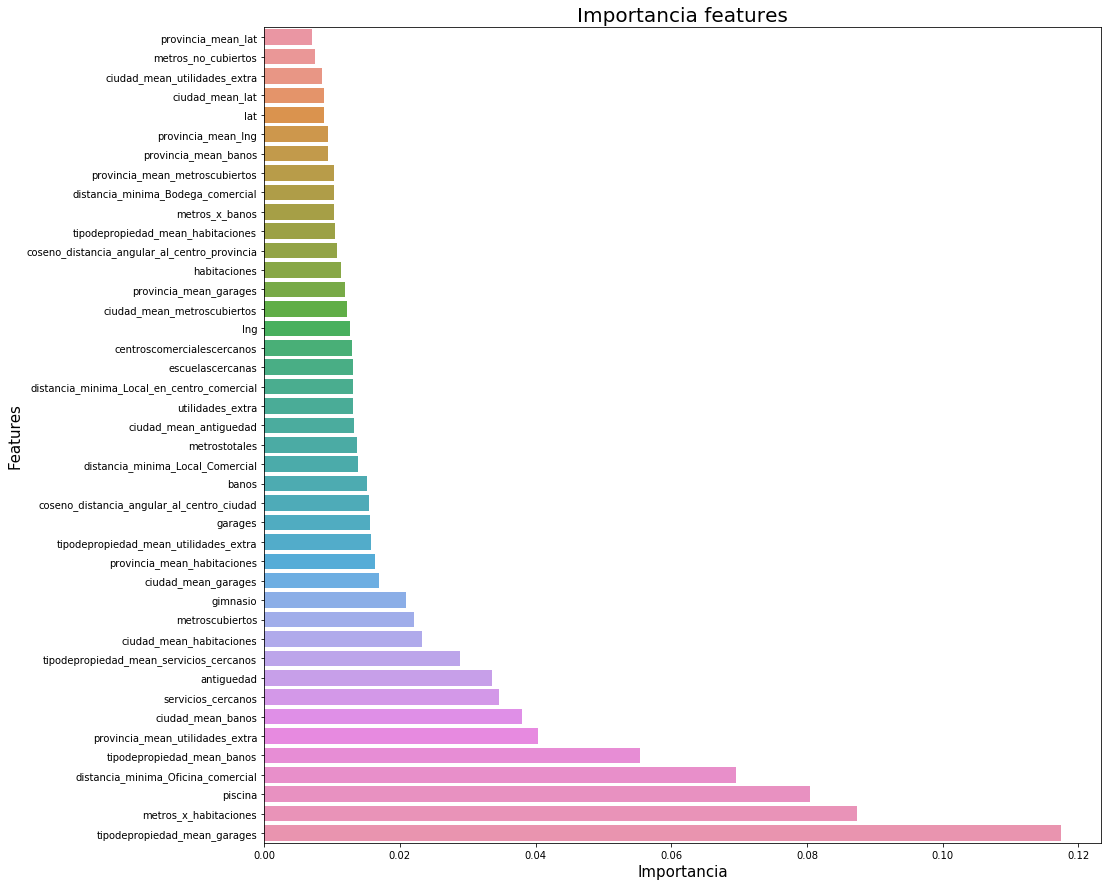

In [49]:
nombres_importancia_1 = plot_importance(rf_regressor, X_train_1.columns)

In [0]:
drop_columns_2 = ['escuelascercanas', 'centroscomercialescercanos', 'usosmultiples',
       'servicios_cercanos', 'piscina', 'gimnasio', 'metros_no_cubiertos',
       'utilidades_extra', 'ratio_metros_cubiertos', 'provincia_mean_lng',
       'distancia_minima_Terreno_comercial',
       'distancia_minima_Local_Comercial', 'provincia_mean_garages',
       'tipodepropiedad_mean_servicios_cercanos',
       'provincia_mean_utilidades_extra', 'antiguedad',]
FEATURES_2 = list((set(FEATURES) - set(drop_columns_1)) - set(drop_columns_2))

In [0]:
X_train_2, XX_test_2, y_train_2, y_test_2 = train_test_split(train[FEATURES_2], train[TARGET], test_size=0.2, random_state=12)

In [47]:
rf_regressor.fit(X_train_2, y_train_2)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features=5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [48]:
evaluar_modelo(rf_regressor, XX_test_2, y_test_2)

Performance del modelo:
Average Error: 611509.0423 degrees.
Accuracy = 69.13%.


69.12954964082337

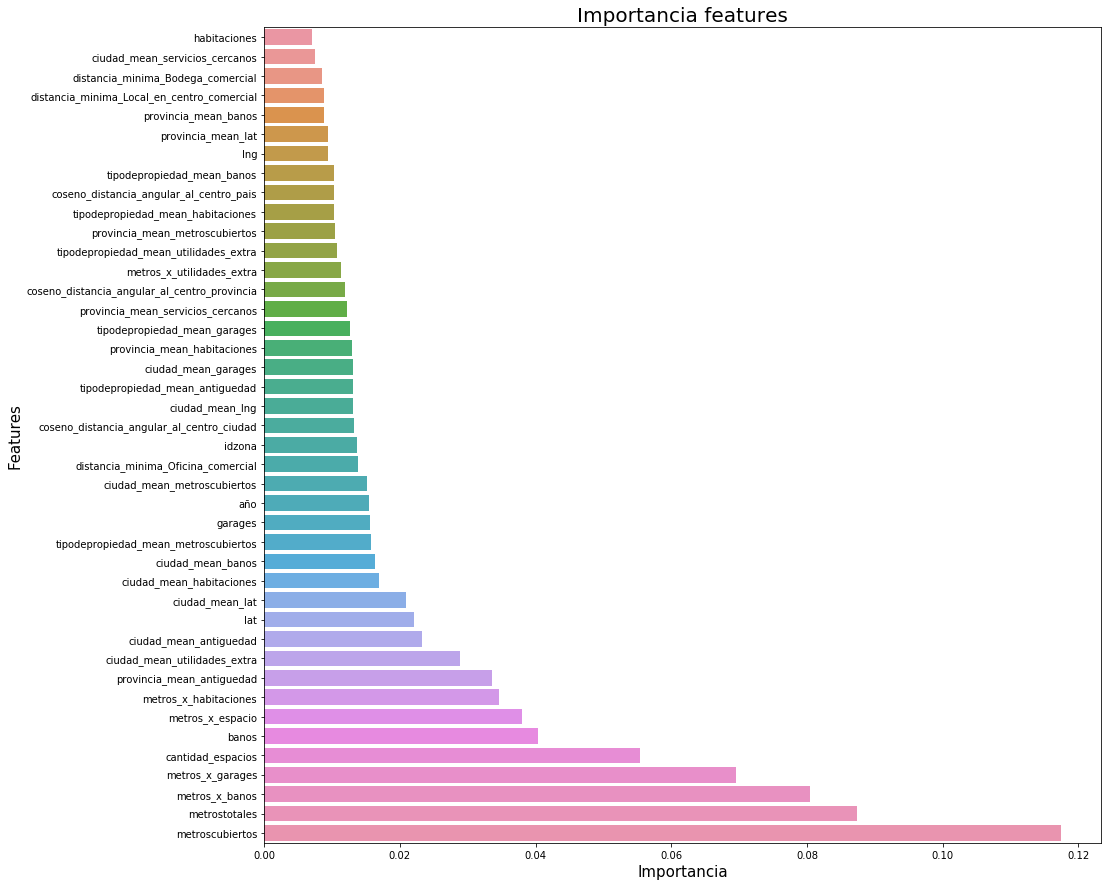

In [51]:
nombres_importancia_2 = plot_importance(rf_regressor, X_train_2.columns)

In [0]:
params_2 = {'max_depth': 15, 'max_features': 10, 'n_estimators': 200}
rf_regressor_2 = RandomForestRegressor(**params)

In [53]:
rf_regressor_2.fit(X_train_2, y_train_2)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features=5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [55]:
evaluar_modelo(rf_regressor_2, XX_test_2, y_test_2)

Performance del modelo:
Average Error: 610773.9435 degrees.
Accuracy = 69.18%.


69.18035105509841

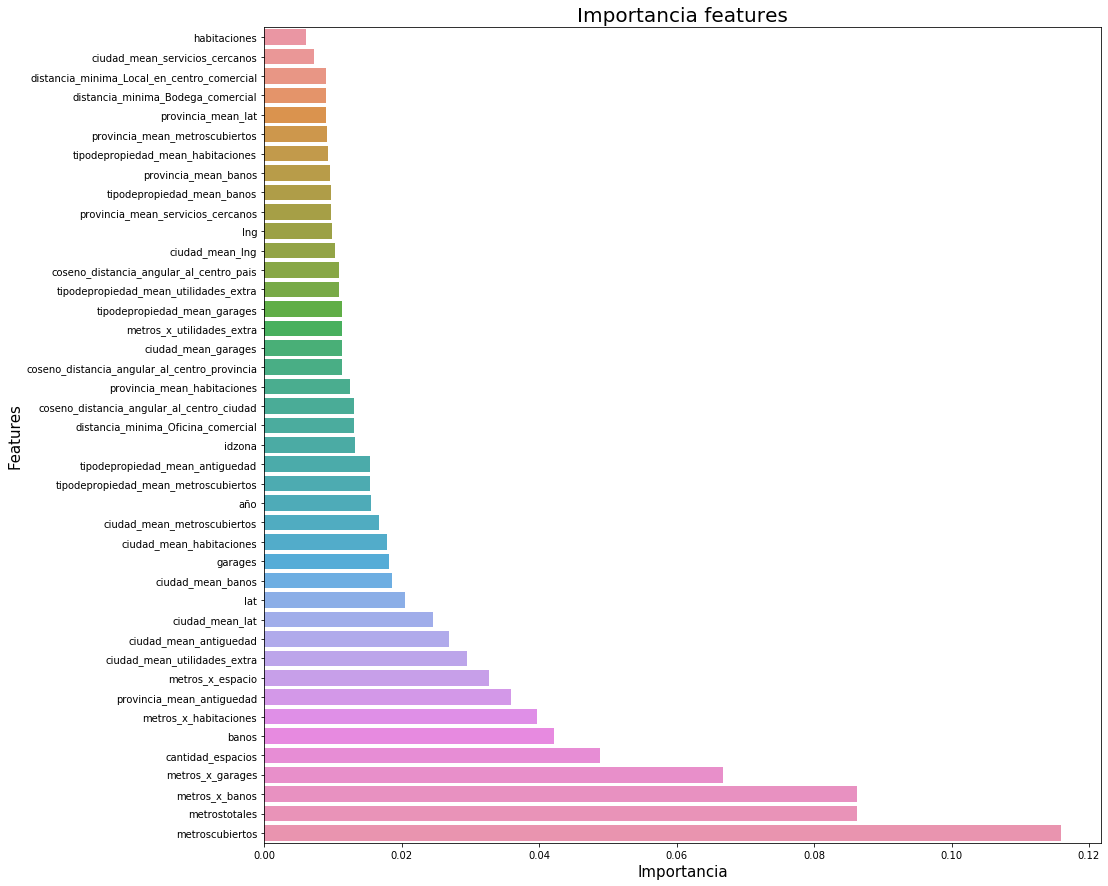

In [54]:
nombres_importancia_2 = plot_importance(rf_regressor_2, X_train_2.columns)

In [0]:
import xgboost as xgb
from xgboost import XGBRegressor

In [0]:
hyper_parametros = {
  'gamma': 2.13,
  'lambda': 1.22,
  'learning_rate': 0.03,
  'max_depth': 15,
  'n_estimators': 200,
}
xgb_regressor = XGBRegressor(objective = 'reg:squarederror', **hyper_parametros)

In [0]:
X_train_3, XX_test_3, y_train_3, y_test_3 = train_test_split(train[FEATURES_1], train[TARGET], test_size=0.2, random_state=13)

In [59]:
xgb_regressor.fit(X_train_3, y_train_3)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=2.13,
             importance_type='gain', lambda=1.22, learning_rate=0.03,
             max_delta_step=0, max_depth=15, min_child_weight=1, missing=None,
             n_estimators=200, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=1, verbosity=1)

In [60]:
evaluar_modelo(xgb_regressor, XX_test_3, y_test_3)

Performance del modelo:
Average Error: 542328.7626 degrees.
Accuracy = 74.17%.


74.1661999085967

Text(0, 0.5, 'Feature Importance Score')

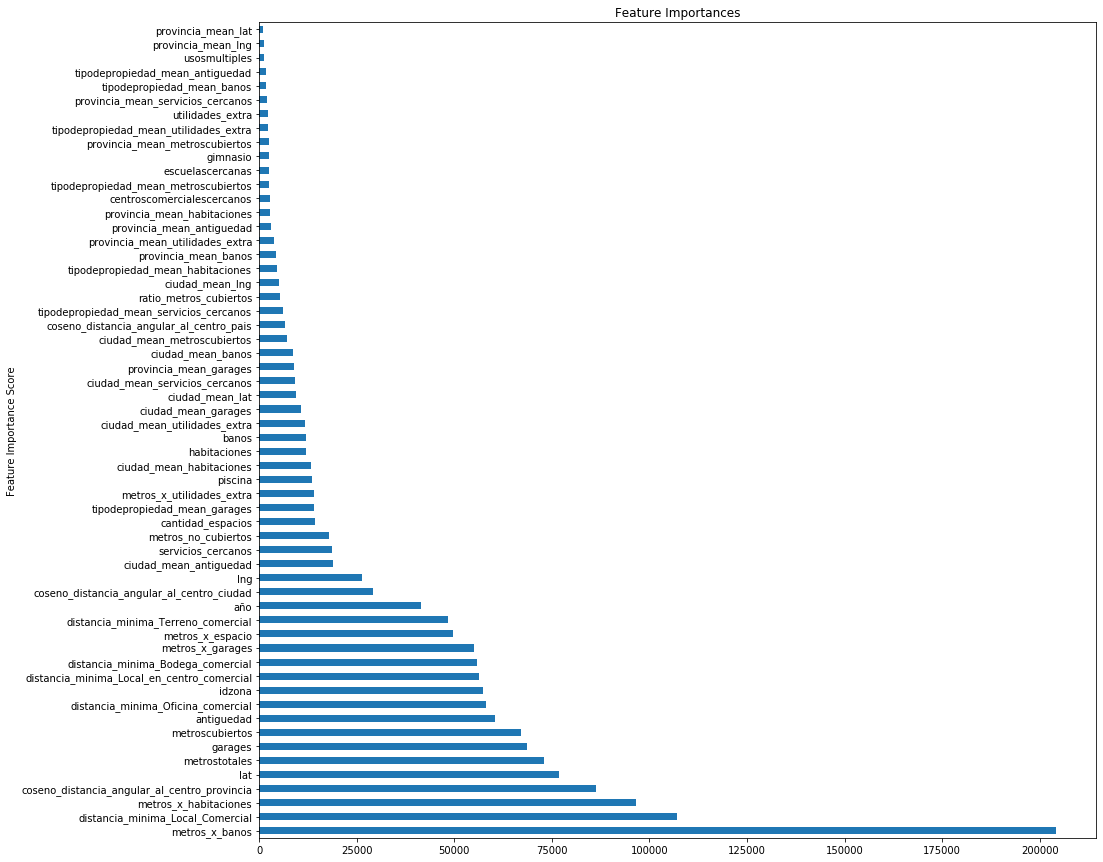

In [65]:
feat_imp_1 = pd.Series(xgb_regressor.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp_1.plot(kind='barh', title='Feature Importances', figsize=(15, 15))
plt.ylabel('Feature Importance Score')

In [66]:
feat_imp_1

metros_x_banos                                  204255
distancia_minima_Local_Comercial                107161
metros_x_habitaciones                            96479
coseno_distancia_angular_al_centro_provincia     86295
lat                                              76912
metrostotales                                    73089
garages                                          68654
metroscubiertos                                  67206
antiguedad                                       60318
distancia_minima_Oficina_comercial               58115
idzona                                           57331
distancia_minima_Local_en_centro_comercial       56266
distancia_minima_Bodega_comercial                55837
metros_x_garages                                 55047
metros_x_espacio                                 49657
distancia_minima_Terreno_comercial               48341
año                                              41474
coseno_distancia_angular_al_centro_ciudad        29186
lng       